In [35]:
import os
import glob
import pandas as pd

expected_columns = ['logtime', 'scenario_time', 'type', 'module', 'address', 'value']

result_dir = './locales/result'
result_files = glob.glob(os.path.join(result_dir, '*.csv'))

all_perf_rows = []

for file in result_files:
    with open(file, 'r') as f:
        lines = f.readlines()
        scenario_line = lines[1].strip()
        # Find the last .txt in the line and extract the scenario name
        if '.txt' in scenario_line:
            txt_part = scenario_line.split('.txt')[0]
            scenario_filename = txt_part.split('/')[-1].split('\\')[-1]
            scenario = scenario_filename
        else:
            scenario = scenario_line  # fallback
    user = os.path.basename(file).split('_')[1]
    df = pd.read_csv(file, skiprows=2)
    if len(df.columns) >= len(expected_columns):
        df.columns = expected_columns + list(df.columns[len(expected_columns):])
    else:
        missing = len(expected_columns) - len(df.columns)
        df.columns = list(df.columns) + ['unknown'] * missing
    # Only keep performance rows and exclude genericscales
    if 'type' in df.columns and 'module' in df.columns:
        perf_rows = df[(df['type'] == 'performance') & (df['module'] != 'genericscales')]
    else:
        perf_rows = pd.DataFrame()
    exclude_cols = [col for col in perf_rows.columns if 'timestamp' in col.lower()] + ['logtime', 'scenario_time', 'type']
    perf_rows = perf_rows.drop(columns=exclude_cols, errors='ignore')
    perf_rows['scenario'] = scenario
    perf_rows['user'] = user
    perf_rows['task_type'] = perf_rows['module'].apply(lambda x: x.split('_')[0])
    perf_rows = perf_rows.drop(columns=['module'])
    all_perf_rows.append(perf_rows)

perf_df = pd.concat(all_perf_rows, ignore_index=True)
# scenario_task_tables now contains the grouped tables for each scenario and task_type

agg:             scenario  avg_hits  avg_misses  avg_response_time
0      noexplanation  0.615385    0.358974        4466.666667
1  visualexplanation  0.545455    0.393939        4244.444444
2   vocalexplanation  0.290909    0.254545        3875.000000
3      vvexplanation  0.339623    0.207547        3788.888889


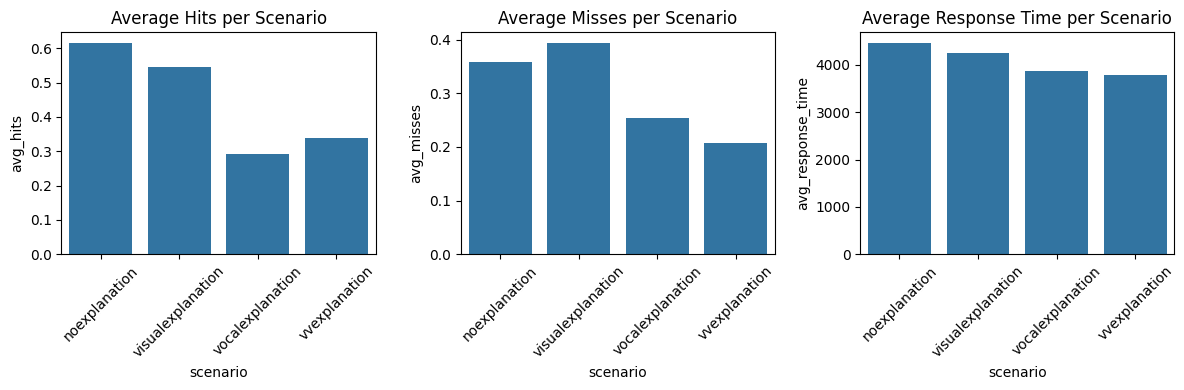

In [36]:
# Aggregate sysmon HIT/MISS counts and response times per scenario
sysmon_df = perf_df[perf_df['task_type'] == 'sysmon']

# Get HIT/MISS events
signal_df = sysmon_df[sysmon_df['address'] == 'signal_detection'].copy()
signal_df['is_hit'] = (signal_df['value'] == 'HIT').astype(int)
signal_df['is_miss'] = (signal_df['value'] == 'MISS').astype(int)

# Get response times
response_df = sysmon_df[sysmon_df['address'] == 'response_time'].copy()
response_df['response_time'] = pd.to_numeric(response_df['value'], errors='coerce')

# Aggregate by scenario
agg_hits = signal_df.groupby('scenario')['is_hit'].mean().reset_index(name='avg_hits')
agg_misses = signal_df.groupby('scenario')['is_miss'].mean().reset_index(name='avg_misses')
agg_response = response_df.groupby('scenario')['response_time'].mean().reset_index(name='avg_response_time')

# Merge results
agg = agg_hits.merge(agg_misses, on='scenario').merge(agg_response, on='scenario')
print(f'agg: {agg}')

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.barplot(x='scenario', y='avg_hits', data=agg)
plt.title('Average Hits per Scenario')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x='scenario', y='avg_misses', data=agg)
plt.title('Average Misses per Scenario')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x='scenario', y='avg_response_time', data=agg)
plt.title('Average Response Time per Scenario')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

agg:             scenario  avg_hits  avg_misses  avg_response_time
0      noexplanation       0.0         1.0                NaN
1  visualexplanation       0.0         1.0                NaN
2   vocalexplanation       0.0         1.0                NaN
3      vvexplanation       0.0         1.0                NaN
            scenario  avg_sdt_value  avg_response_time
0      noexplanation            NaN                NaN
1  visualexplanation            NaN                NaN
2   vocalexplanation            NaN                NaN
3      vvexplanation            NaN                NaN


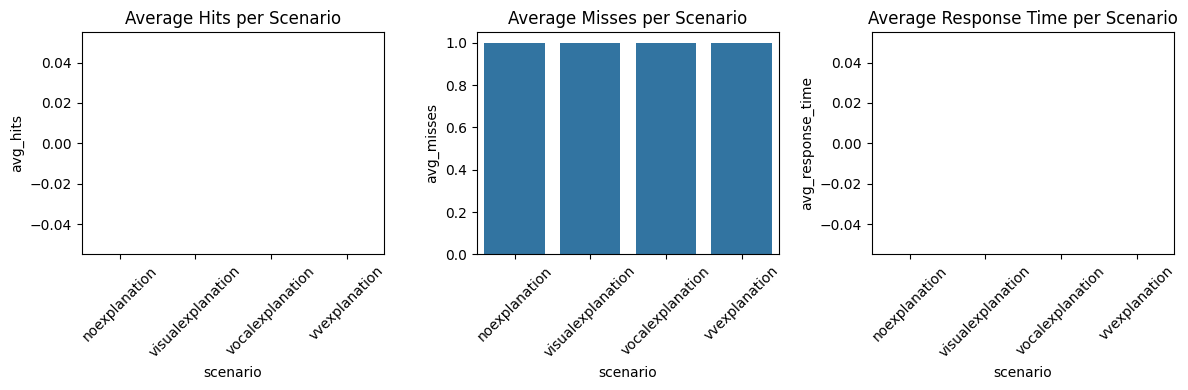

In [57]:
# Aggregate for communication (base type only)
comm_df = perf_df[perf_df['task_type'] == 'communications']

# Get std_value and response_time
std_df = comm_df[comm_df['address'] == 'sdt_value'].copy()

std_df['is_hit'] = (std_df['value'] == 'HIT').astype(int)
std_df['is_miss'] = (std_df['value'] == 'MISS').astype(int)
std_df['sdt_value'] = pd.to_numeric(std_df['value'], errors='coerce')

# Get response times
response_df = comm_df[comm_df['address'] == 'response_time'].copy()
response_df['response_time'] = pd.to_numeric(response_df['value'], errors='coerce')


# Aggregate by scenario
agg_hits = std_df.groupby('scenario')['is_hit'].mean().reset_index(name='avg_hits')
agg_misses = std_df.groupby('scenario')['is_miss'].mean().reset_index(name='avg_misses')
agg_response = response_df.groupby('scenario')['response_time'].mean().reset_index(name='avg_response_time')

# Merge results
agg = agg_hits.merge(agg_misses, on='scenario').merge(agg_response, on='scenario')
print(f'agg: {agg}')

# Aggregate by scenario
agg_std = std_df.groupby('scenario')['sdt_value'].mean().reset_index(name='avg_sdt_value')
agg_response = response_df.groupby('scenario')['response_time'].mean().reset_index(name='avg_response_time')

# Merge results
agg_comm = agg_std.merge(agg_response, on='scenario')
print(agg_comm)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.barplot(x='scenario', y='avg_hits', data=agg)
plt.title('Average Hits per Scenario')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x='scenario', y='avg_misses', data=agg)
plt.title('Average Misses per Scenario')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x='scenario', y='avg_response_time', data=agg)
plt.title('Average Response Time per Scenario')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
